In [32]:
import os,shutil
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
# Ignore warnings
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [4]:
## use gdown in google collab to download training data. 
# !gdown --id '1zg5EDls7E4ZnkWzPKh_XNkw564ns22mq'

In [21]:
class pavement_data(Dataset):
    def __init__(self, root_dir, csv_path):
        self.root = Path(root_dir)

        self.df = pd.read_csv(os.path.join(root_dir,csv_path))
        self.df = self.df.sample(frac=1)
        self.image_names = [os.path.join(self.root,'train',i) for i in self.df['image_name'].values]
        self.pci_label = list(self.df['pci'].values)

    def __len__(self):
        # returns the length of the dataset
        return len(self.image_names)

    def __getitem__(self, idx):

    #     # preprocess and transformations
    #     # indexes the dataset such that dataset[i] can retrieve the ith sample.
        image = self.image_names[idx]
        # print (image)
        if os.path.isfile(image):
            image_data = io.imread(image)
            # print (image_data)

            label = self.pci_label[idx]

            sample = {'image': image_data, 'image_path':image,'label': label}

            return sample

In [34]:
pavement_dataset = pavement_data('data','train.csv')

In [36]:
for idx, sample in enumerate(pavement_dataset):
    print (sample['image'].shape, sample['label'])

    if idx == 5:
        break

(1536, 1536, 3) 4
(1536, 1536, 3) 48
(1536, 1536, 3) 85
(1536, 1536, 3) 100
(1536, 1536, 3) 59
(1536, 1536, 3) 91


In [37]:
def plot_data(pavement_dataset,cls_thresh,num_samples):
  fig = plt.figure(figsize=(20,20))
  ncols = int(np.floor(num_samples/2))+1
  cnt = 0
  df = pavement_dataset.df
  df['image_names'] = pavement_dataset.image_names
  df = df[df['pci'].between(cls_thresh[0],cls_thresh[1])]
  df = df.sample(frac=1)
  df = df.reset_index()
  
  fig, axs = plt.subplots(2, ncols, figsize=(20, 10))

  for i, sample in df.iterrows():
    plt.tight_layout()
    axs[int(i/ncols), (i%ncols)].set_title('Sample PCI - {}'.format(sample['pci']))
    axs[int(i/ncols), (i%ncols)].imshow(io.imread(sample['image_names']))
    axs[int(i/ncols), (i%ncols)].axis('off')
    if i+1 == ncols*2:
      plt.show()
      break
  plt.show()

<Figure size 2000x2000 with 0 Axes>

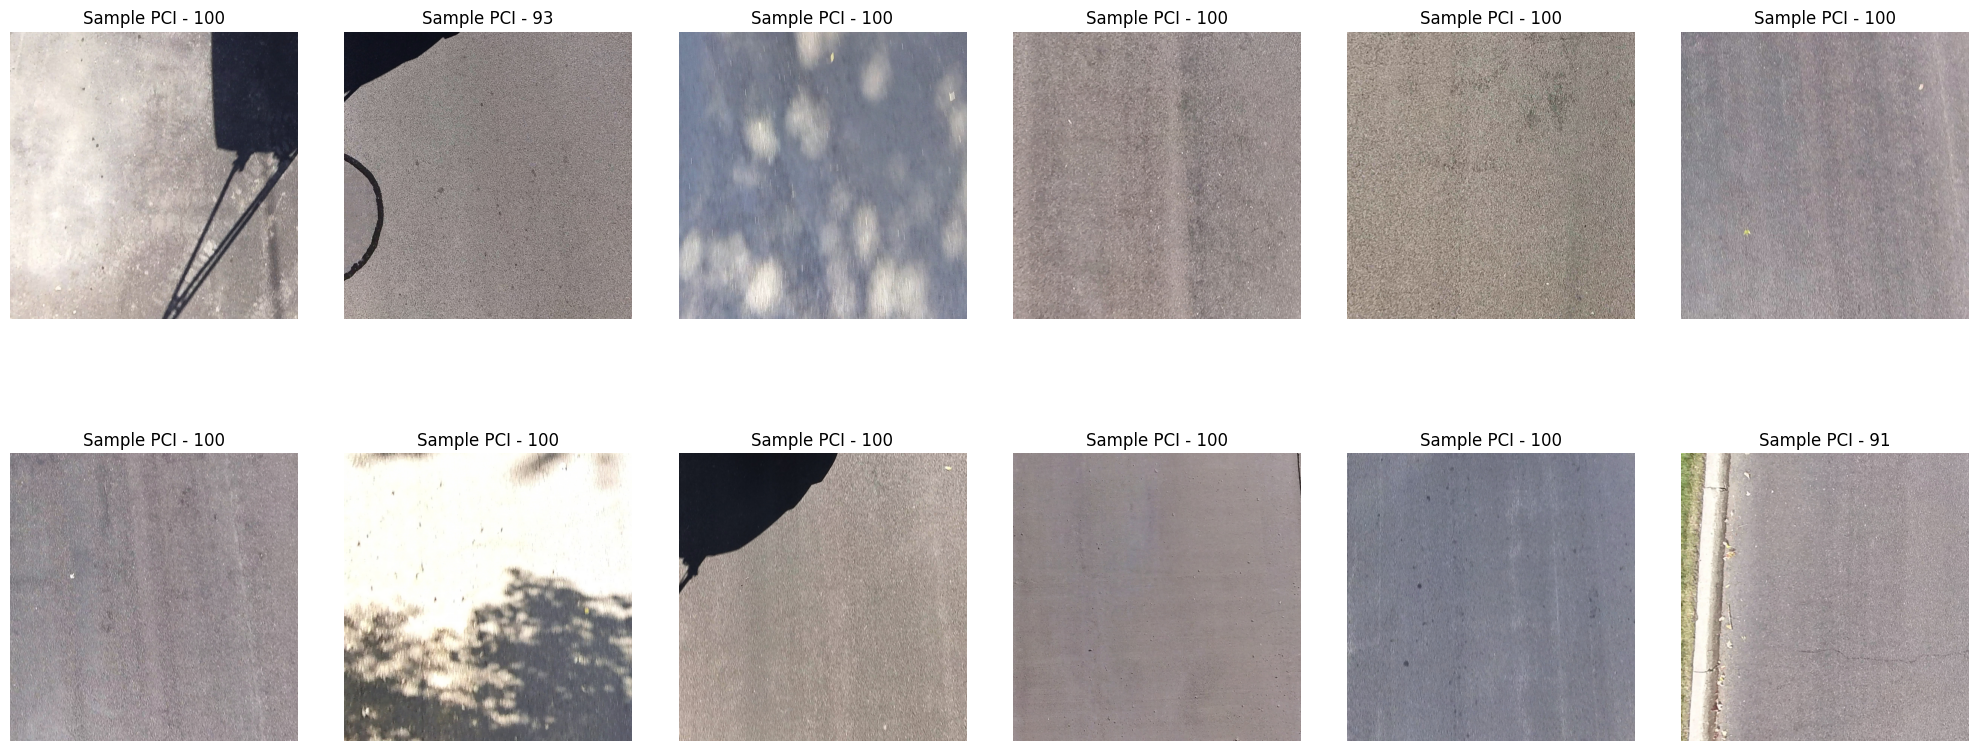

In [40]:
plot_data(pavement_dataset,(90,100),10)

In [3]:
class prep_data(object):
  def __init__(self,root_dir,csv_path):
    self.root = Path(root_dir)
    self.df = pd.read_csv(os.path.join(root_dir,csv_path))
    self.image_names = [os.path.join(self.root,'train',i) for i in self.df['image_name'].values]
    self.pci_label = list(self.df['pci'].values)
    self.train_folder = os.path.join(root_dir,'yolov8','train')
    self.val_folder = os.path.join(root_dir,'yolov8','val')
    Path(self.train_folder).mkdir(parents=True, exist_ok=True)
    Path(self.val_folder).mkdir(parents=True, exist_ok=True)

  def __call__(self,sample):
    if not sample is None:
      image, img_path, labels = sample['image'],sample['image_path'], sample['label']
      # print (img_path)
      # print (labels)
      dst_folder = os.path.join(self.train_folder,str(labels))
      Path(dst_folder).mkdir(parents=True, exist_ok=True)
      fname = os.path.basename(img_path)
      if not os.path.isfile(os.path.join(dst_folder,fname)):
        shutil.copy2(img_path,dst_folder)

In [41]:
obj_prep = prep_data('data','train.csv')

In [42]:
for i, sample in enumerate(tqdm(pavement_dataset)):
    obj_prep(sample)

 61%|██████    | 4688/7704 [03:44<02:24, 20.89it/s]


OSError: Could not find a backend to open `data/train/1119_(40.7034233333333, -89.4052588333333)_ 2023-10-18 15-49-01_14.30605_D.jpg`` with iomode `r`.
Based on the extension, the following plugins might add capable backends:
  pyav:  pip install imageio[pyav]

In [72]:
from ultralytics import YOLO

In [147]:
model = YOLO('yolov8n-cls.pt')
# model = YOLO('runs/classify/train3/weights/last.pt')
# model.train(data='dsps/yolov8', epochs=100)
model.train(data='dsps/yolov8', resume=True, epochs=3)

New https://pypi.org/project/ultralytics/8.1.10 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.152 🚀 Python-3.9.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12020MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=classify, mode=train, model=runs/classify/train3/weights/last.pt, data=dsps/yolov8, epochs=100, patience=50, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_s

KeyboardInterrupt: 

In [148]:
model = YOLO('runs/classify/train3/weights/last.pt')

In [149]:
test_path = Path('dsps/test/')
rows = []
for tst_img in test_path.glob('**/*.jpg'):
    preds = model(tst_img)
    cls_dict = preds[0].names
    probs = preds[0].probs.data.cpu().numpy()
    rows.append({'image_name':os.path.basename(tst_img),
                 'pci':cls_dict[np.argmax(probs)]})

df_test = pd.DataFrame(rows)


image 1/1 /home/hamed/dev/dsps/test/3910_[40.70800769388502, -89.38938456054692]_ 2023-10-18 16-18-59_22.8697_LD.jpg: 224x224 100 0.98, 88 0.01, 78 0.00, 62 0.00, 64 0.00, 4.5ms
Speed: 69.5ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /home/hamed/dev/dsps/test/6780_(40.7029723333333, -89.4051231666667)_ 2023-10-18 17-02-15_4.22725_D.jpg: 224x224 4 0.97, 11 0.00, 6 0.00, 1 0.00, 2 0.00, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /home/hamed/dev/dsps/test/1101_(40.7033468333333, -89.40616)_ 2023-10-18 15-48-47_16.61855_D.jpg: 224x224 38 1.00, 4 0.00, 42 0.00, 39 0.00, 25 0.00, 4.5ms
Speed: 0.6ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /home/hamed/dev/dsps/test/20513_(40.7089811666667, -89.4348416666667)_ 2023-10-20 19-10-05_2.42905_D.jpg: 224x224 75 0.93, 35 0.02, 56 0.02, 65 0.01, 71 0.01, 3.8ms
Speed: 0.5ms prepr

In [150]:
import json
# df: should have two columns - image_name and PCI
def gen_submit(df):
  out_json = []
  for idx, results in df.iterrows():
    out_json.append({results['image_name']:results['pci']})
  with open('submission.json', 'w') as f:
    json.dump(out_json, f)

In [151]:
df_test['pci'] = df_test['pci'].astype(int)
gen_submit(df_test)

In [152]:
df_test.head()

,image_name,pci
0,"3910_[40.70800769388502, -89.38938456054692]_ ...",100
1,"6780_(40.7029723333333, -89.4051231666667)_ 20...",4
2,"1101_(40.7033468333333, -89.40616)_ 2023-10-18...",38
3,"20513_(40.7089811666667, -89.4348416666667)_ 2...",75
4,"40399_[40.71426820356199, -89.43796371571018]_...",62
